## Modeling Adstock

In this section, users will learn how to input a pre-defined adstock weights into the MMM fitting process.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM
from karpiu.utils import insert_events, extend_ts_features

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 50)

print(karpiu.__version__)

0.0.1


In [2]:
%load_ext autoreload
%autoreload 2

### Data Input

Recall in quickstart, a demo on training a dataset without adstock is shown. This time the demo will add an extra arguement `adstock_df` which is prepared by the user.

In [5]:
RAW_DATA_FILE = "resource/full/df.csv"
SCALABILITY_FILE = "resource/full/scalability_df.csv"
ADSTOCK_FILE = "resource/full/adstock_df.csv"
paid_channels = ["promo", "radio", "search", "social", "tv"]

This is the core spend and response(the sales) input data.

In [6]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=["date"])
scalability_df = pd.read_csv(SCALABILITY_FILE)
adstock_df = pd.read_csv(ADSTOCK_FILE, index_col="regressor")

In [7]:
event_cols = [
    "new-years-day", 
    "martin-luther-king-jr-day", 
    "washingtons-birthday",
    "memorial-day",
    "independence-day", 
    "labor-day",
    "columbus-day",
    "veterans-day", 
    "thanksgiving",
    "christmas-day",
    "independence-day-observed",
    "juneteenth-national-independence-day-observed",
    "juneteenth-national-independence-day",
    "christmas-day-observed",
    "new-years-day-observed"
]

### Fitting a MMM

In [8]:
mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=event_cols,
    seed=2022,
    adstock_df=adstock_df,
    seasonality=[7, 365.25],
    fs_orders=[2, 3],
    events_sigma_prior=0.3,
)

2023-05-15 20:31:59 - karpiu-mmm - INFO - Initialize model


For now, users can skip the hyper-parameters fitting section and directly set some prepared hyper-parameters.

In [9]:
best_params = {
    "damped_factor": 0.949,
    "level_sm_input": 0.00245,
}
mmm.set_hyper_params(best_params)

2023-05-15 20:32:00 - karpiu-mmm - INFO - Set hyper-parameters.
2023-05-15 20:32:00 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-05-15 20:32:00 - karpiu-mmm - INFO - Best params level_sm_input set as 0.00245


Fit the model with supplied dataframe.

Feel free to use more chains if the machine running the model has multiple cores.

In [10]:
mmm.fit(df, num_sample=1000, num_warmup=1000, chains=1)

2023-05-15 20:32:01 - karpiu-mmm - INFO - Fit final model.
2023-05-15 20:32:01 - karpiu-mmm - INFO - Deriving saturation constants...
2023-05-15 20:32:01 - karpiu-mmm - INFO - Derived saturation constants.
2023-05-15 20:32:01 - karpiu-mmm - INFO - Build a default regression scheme
2023-05-15 20:32:01 - orbit - INFO - Sampling (PyStan) with chains: 1, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 1000.


chain 1 |          | 00:00 Status

2023-05-15 20:34:38 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.5374089) is within common range (0, 0.8].


### Model Regression Coefficents

Now, we can see all the Fourier and event terms regression coefficient.

In [11]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.05255,0.03456,0.07006,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.06735,0.05311,0.08086,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.20125,0.17754,0.22308,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.12660,0.10857,0.14522,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.08967,0.06776,0.11162,1.00000,0.00000,0.00000,0.10000
5,s7_fs_cos1,Regular,0.54939,0.54569,0.55323,1.00000,0.00000,0.00000,0.30000
6,s7_fs_cos2,Regular,0.38301,0.37936,0.38661,1.00000,0.00000,0.00000,0.30000
7,s7_fs_sin1,Regular,-0.66121,-0.66493,-0.65745,0.00000,1.00000,0.00000,0.30000
8,s7_fs_sin2,Regular,-0.34166,-0.34541,-0.33795,0.00000,1.00000,0.00000,0.30000
9,s365.25_fs_cos1,Regular,0.15419,0.14588,0.16302,1.00000,0.00000,0.00000,0.30000


### Forecast Future Outcome

Prediction interval is not supported yet but will be available in future version. Here a demo of using `insert_event` and `extend_ts_features` are also shown to generate future dataframe for long-term forecast checking.

In [12]:
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

In [13]:
future_df = extend_ts_features(df, 365, date_col="date")
future_df, event_cols = insert_events(future_df, date_col="date", country="US")

In [14]:
pred_df = mmm.predict(future_df)

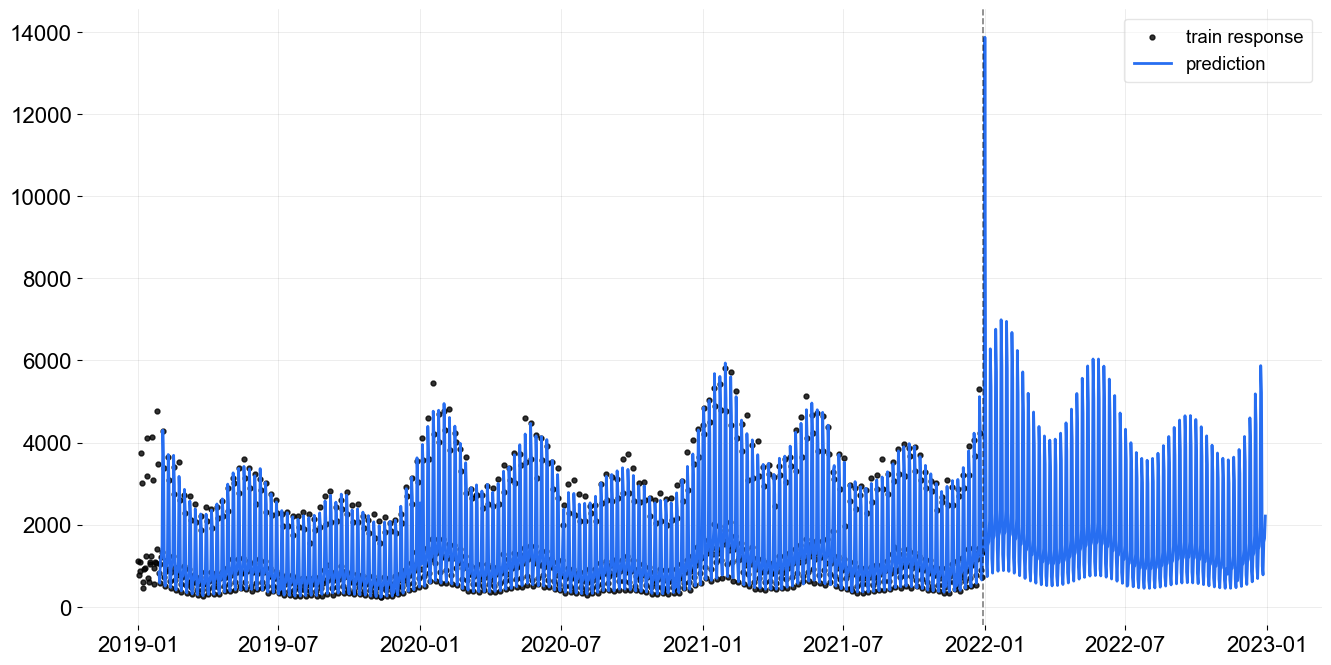

In [15]:
plot_predicted_data(
    training_actual_df=df,
    predicted_df=pred_df,
    date_col="date",
    actual_col="sales",
);

In [16]:
pred_df = mmm.predict(future_df, decompose=True)

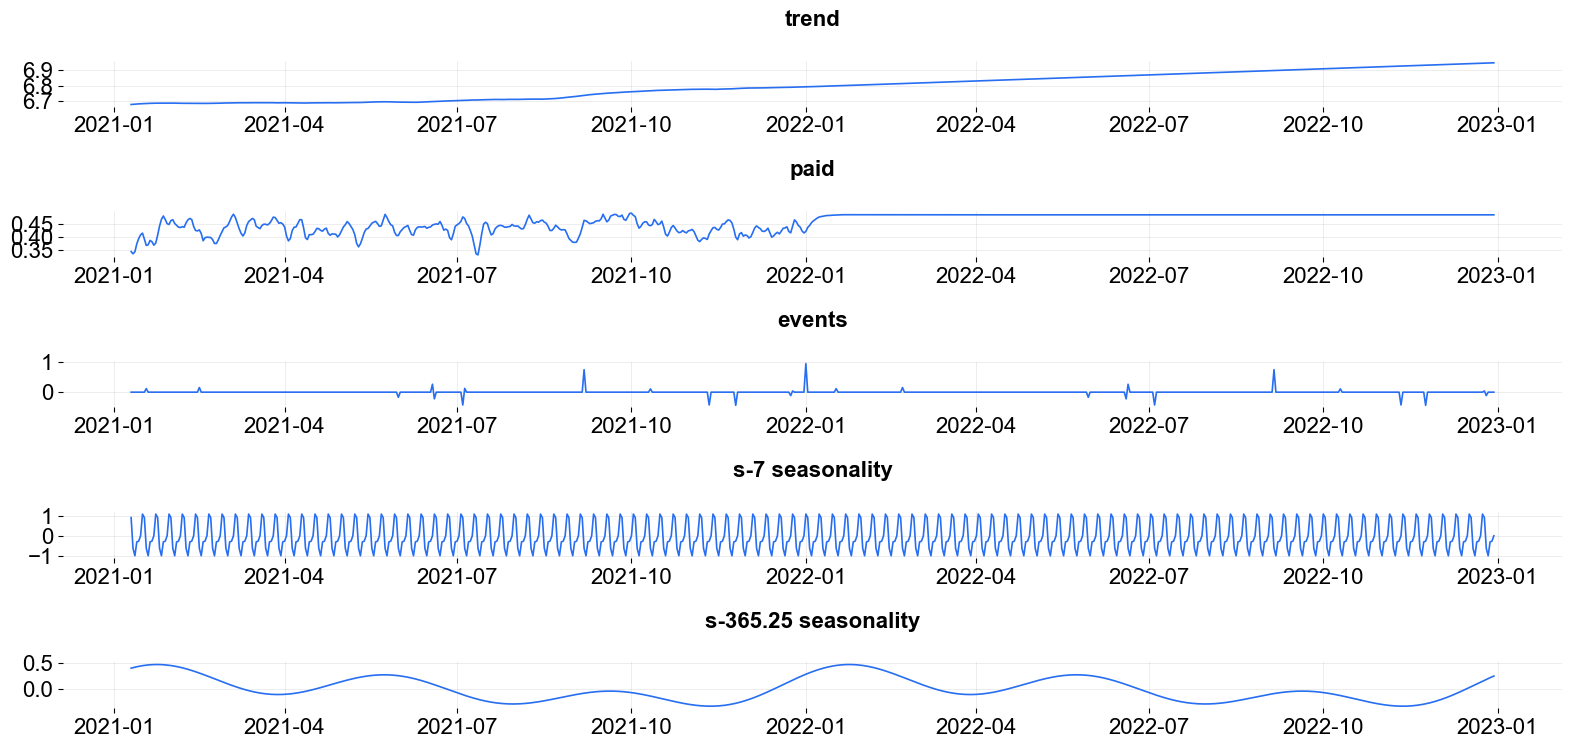

In [17]:
plot_predicted_components(
    predicted_df=pred_df[-720:],
    date_col="date",
    plot_components=[
        "trend",
        "paid",
        "events",
        "s-7 seasonality",
        "s-365.25 seasonality",
    ],
);

In [18]:
import pickle

with open("./resource/full/model.pkl", "wb") as f:
    pickle.dump(mmm, f, protocol=pickle.HIGHEST_PROTOCOL)